<a href="https://colab.research.google.com/github/DhekerKacem/FuturVisionTransport/blob/main/modelisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

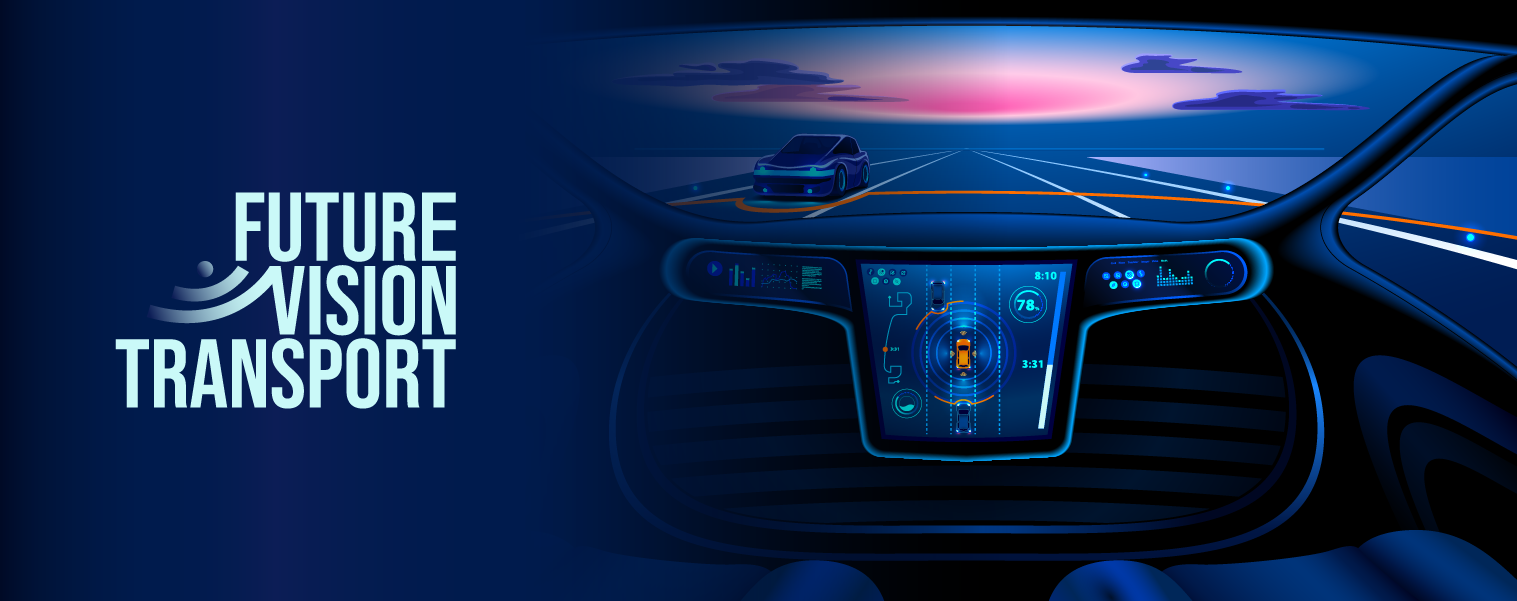

###Traitez les images pour le système embarqué d’une voiture autonome

### Présentation du projet

Future Vision Transport est une entreprise qui conçoit des systèmes embarqués de vision par ordinateur pour les véhicules autonomes.

Vous êtes l’un des ingénieurs IA au sein de l’équipe R&D de cette entreprise. Votre équipe est composée d’ingénieurs aux profils variés. Chacun des membres de l’équipe est spécialisé sur une des parties du système embarqué de vision par ordinateur.

Voici les différentes parties du système :

acquisition des images en temps réel
traitement des images
segmentation des images (c’est notre mission)
système de décision

Notre rôle est de concevoir un premier modèle de segmentation d’images qui devra s’intégrer facilement dans la chaîne complète du système embarqué.

Dans cette première partie, notre mission sera, donc, d'entrainer plusieurs modèles de machine learning et de retenir celui qui produit les meilleures performances ( temps de clacul et score IOU (Intersection Over Union).

La deuxième partie du projet consistera en le déploiement de ce modèle sur le cloud (Azure) à travers la conception d'une API.

Et enfin, la troisième partie sera consacrée à la conception d'une application web de représentation des résultats. Pour se faire, nous utiliserons Flask et Streamlit.

In [ ]:
pip install imgaug

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun May 26 12:47:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              49W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Chargement des bibliothèques

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cv2
import random
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Conv2DTranspose, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import backend as K

### Présentation des données et choix des fichiers utilisés

Les données qui vont servir à réaliser ce projet sont celles de CityScapes qui fournit un jeu de données de 3000 images d'une caméra embarquée. Ces images sont fournies avec leurs masques annotés des différents labels de segmentation.

En tout, il existe 8 catégories et 32 sous catégories. Pour les besoins de ce projet nous n'utiliseron que les 8 catégories principales.


Group	Classes
flat:	road, sidewalk, parking,  rail,  track
human:	person, rider
vehicle:	car, truck, on rails, motorcycle, bicycle, caravan, trailer
construction:	building, wall, fence, guard, rail, bridge, tunnel
object:	pole, pole group, traffic sign, traffic light
nature:	vegetation, terrain
sky:	sky
void:	ground, dynamic, static


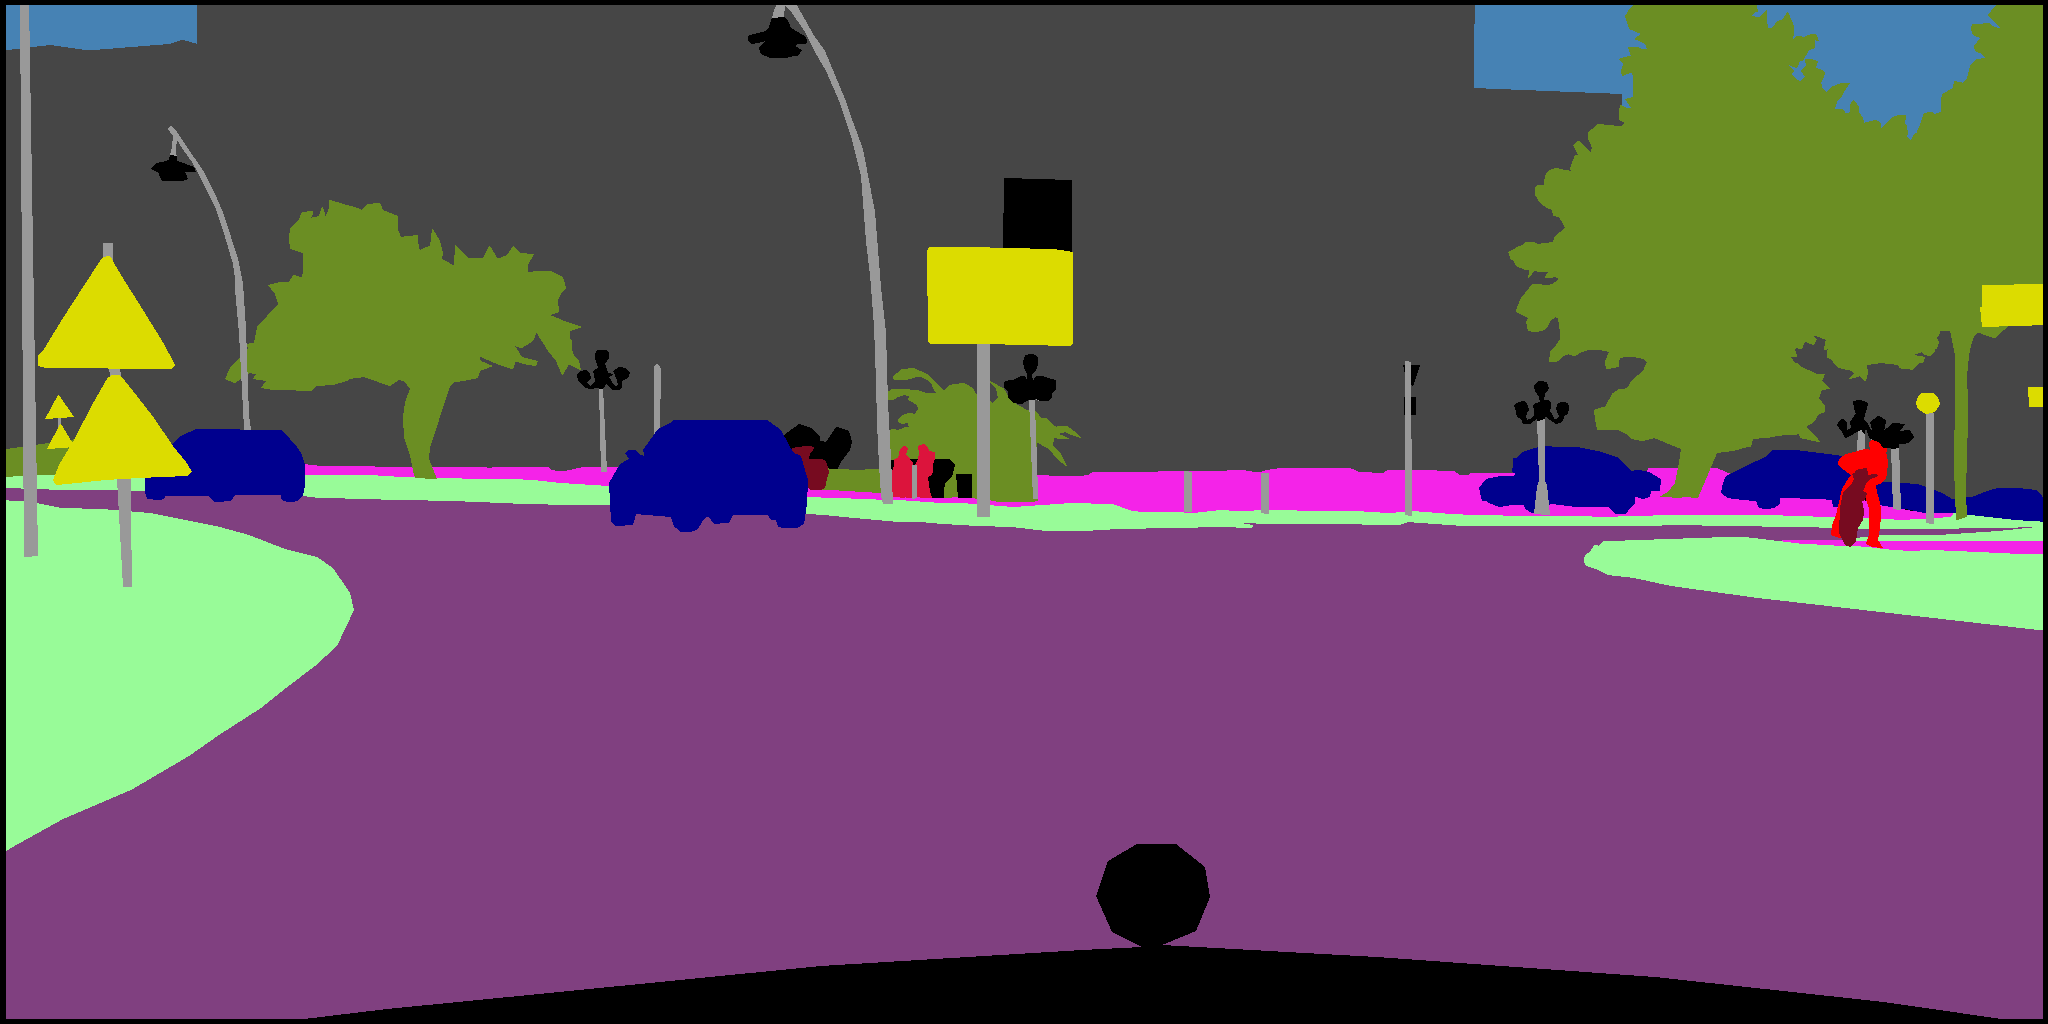






Original Mask 1 Unique Labels: [  0  16  70  84  90 108 117 119 153 164 177 194]
Converted Mask 1 Unique Labels: [0 2]


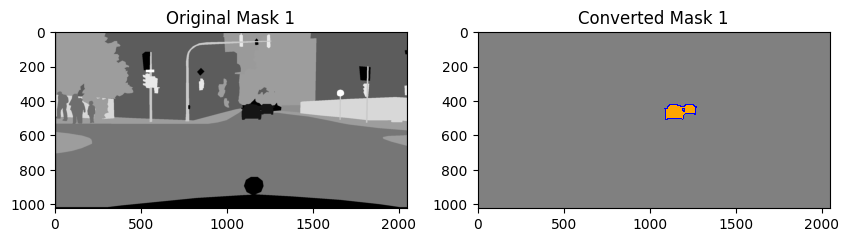

Original Mask 2 Unique Labels: [  0  16  26  33  70  90 117 119 153 177 192 194 210]
Converted Mask 2 Unique Labels: [0 2 7]


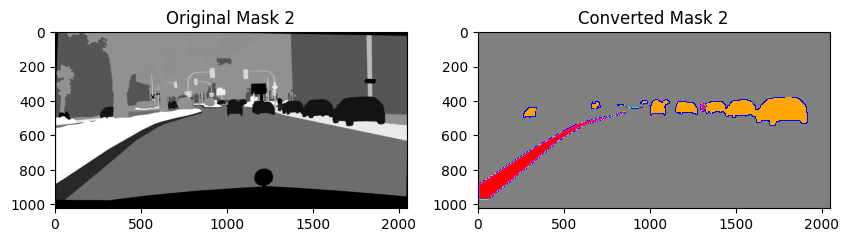

Original Mask 3 Unique Labels: [  0  33  45  70  76  84  90 108 117 119 125 153 164 172 177 194]
Converted Mask 3 Unique Labels: [0 7]


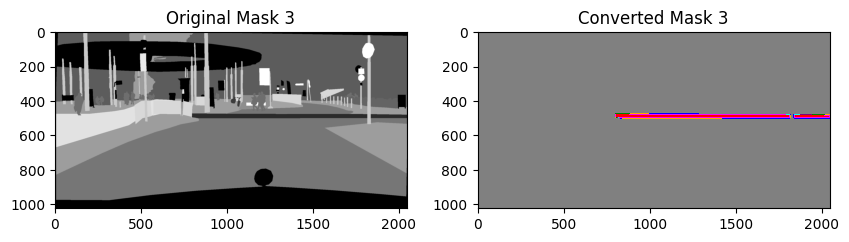

Original Mask 4 Unique Labels: [  0  70  90 108 114 117 119 153 164 194]
Converted Mask 4 Unique Labels: [0]


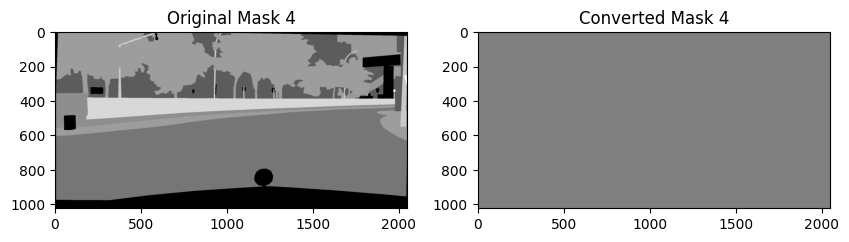

Original Mask 5 Unique Labels: [  0  16  45  70  76  84  90 117 119 153 192 194]
Converted Mask 5 Unique Labels: [0 2]


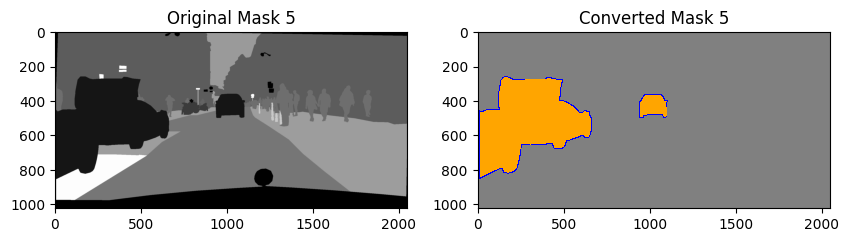

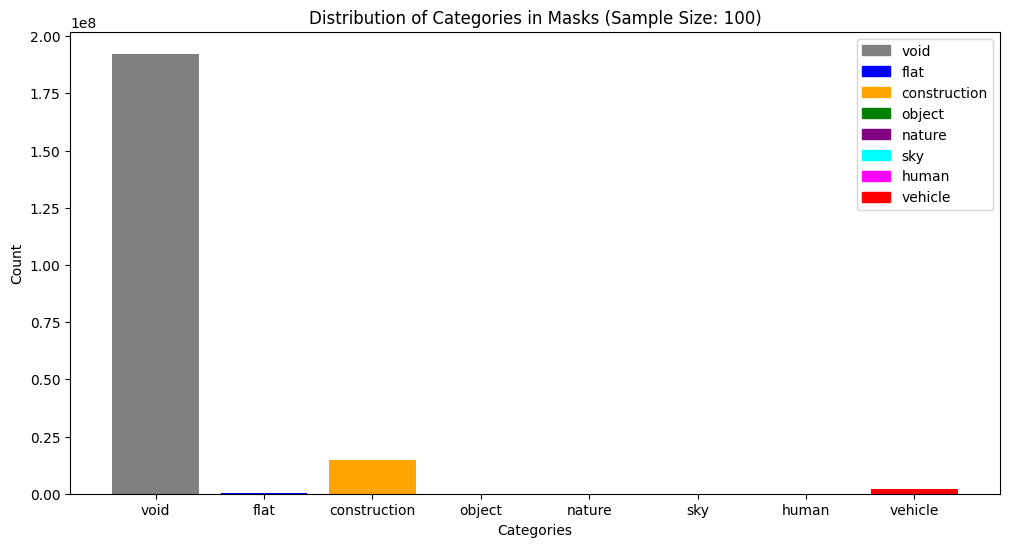

In [ ]:
# Définir les catégories et les couleurs
CATS = {
    'void': [0, 1, 2, 3, 4, 5, 6],
    'flat': [7, 8, 9, 10],
    'construction': [11, 12, 13, 14, 15, 16],
    'object': [17, 18, 19, 20],
    'nature': [21, 22],
    'sky': [23],
    'human': [24, 25],
    'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]
}

category_colors = {
    'void': 'gray',
    'flat': 'blue',
    'construction': 'orange',
    'object': 'green',
    'nature': 'purple',
    'sky': 'cyan',
    'human': 'magenta',
    'vehicle': 'red'
}

# Fonction pour convertir les masques
def _convert_mask(img):
    mask = np.zeros((img.shape[0], img.shape[1], 8), dtype=np.uint8)
    for i in range(-1, 34):
        if i in CATS['void']:
            mask[:, :, 0] = np.logical_or(mask[:, :, 0], (img == i))
        elif i in CATS['flat']:
            mask[:, :, 1] = np.logical_or(mask[:, :, 1], (img == i))
        elif i in CATS['construction']:
            mask[:, :, 2] = np.logical_or(mask[:, :, 2], (img == i))
        elif i in CATS['object']:
            mask[:, :, 3] = np.logical_or(mask[:, :, 3], (img == i))
        elif i in CATS['nature']:
            mask[:, :, 4] = np.logical_or(mask[:, :, 4], (img == i))
        elif i in CATS['sky']:
            mask[:, :, 5] = np.logical_or(mask[:, :, 5], (img == i))
        elif i in CATS['human']:
            mask[:, :, 6] = np.logical_or(mask[:, :, 6], (img == i))
        elif i in CATS['vehicle']:
            mask[:, :, 7] = np.logical_or(mask[:, :, 7], (img == i))
    return np.argmax(mask, axis=2).astype('uint8')

# Fonction pour charger les masques et extraire les labels par catégorie
def get_category_distribution(mask_paths):
    category_counts = {cat: 0 for cat in CATS.keys()}
    for mask_path in mask_paths:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        converted_mask = _convert_mask(mask)
        unique, counts = np.unique(converted_mask, return_counts=True)
        for label, count in zip(unique, counts):
            category = list(CATS.keys())[label]
            category_counts[category] += count
    return category_counts

# Fonction pour obtenir les chemins des masques
def get_mask_paths(mask_base_dir, sample_size=None):
    mask_paths = []
    for root, dirs, files in os.walk(mask_base_dir):
        for file in files:
            if file.endswith('_gtFine_color.png'):
                mask_paths.append(os.path.join(root, file))
    if sample_size:
        mask_paths = random.sample(mask_paths, sample_size)
    return mask_paths

# Fonction pour visualiser quelques masques
def visualize_masks(mask_paths, num_samples=5):
    # Définir la palette de couleurs
    colors = [category_colors[cat] for cat in CATS.keys()]
    cmap = mcolors.ListedColormap(colors)
    norm = mcolors.BoundaryNorm(range(len(CATS) + 1), cmap.N)

    for i, mask_path in enumerate(random.sample(mask_paths, num_samples)):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        converted_mask = _convert_mask(mask)

        # Étape de débogage : Afficher les valeurs uniques dans les masques
        print(f"Original Mask {i+1} Unique Labels: {np.unique(mask)}")
        print(f"Converted Mask {i+1} Unique Labels: {np.unique(converted_mask)}")

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title(f'Original Mask {i+1}')
        plt.imshow(mask, cmap='gray')

        plt.subplot(1, 2, 2)
        plt.title(f'Converted Mask {i+1}')
        plt.imshow(converted_mask, cmap=cmap, norm=norm)

        plt.show()

# Chemin vers le répertoire des masques
mask_base_dir = '/content/drive/My Drive//data/gtFine/train'

# Définir la taille de l'échantillon
sample_size = 100  # Vous pouvez ajuster cette valeur selon vos besoins

# Obtenir les chemins des masques avec un échantillon
mask_paths = get_mask_paths(mask_base_dir, sample_size)

# Visualiser quelques masques pour vérifier
visualize_masks(mask_paths)

# Obtenir la distribution des catégories
category_distribution = get_category_distribution(mask_paths)

# Convertir la distribution en DataFrame pour une meilleure visualisation
df = pd.DataFrame(list(category_distribution.items()), columns=['Category', 'Count'])

# Mapper les couleurs pour chaque catégorie
df['Color'] = df['Category'].map(category_colors)

# Afficher la distribution sous forme de bar plot avec des couleurs
plt.figure(figsize=(12, 6))
plt.bar(df['Category'], df['Count'], color=df['Color'])
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title(f'Distribution of Categories in Masks (Sample Size: {sample_size})')

# Ajouter une légende
handles = [plt.Rectangle((0,0),1,1, color=category_colors[cat]) for cat in category_colors]
labels = [cat for cat in category_colors]
plt.legend(handles, labels)

plt.show()


Original Mask 1 Unique Labels: [ 1  3  4  5  6  7  8 11 13 17 20 21 23 24 25 26 33]
Converted Mask 1 Unique Labels: [0 1 2 3 4 5 6 7]


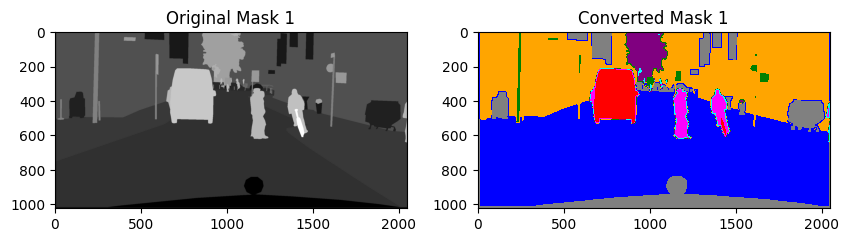

Original Mask 2 Unique Labels: [ 1  3  4  7  8 11 17 19 20 21 24 26 32 33]
Converted Mask 2 Unique Labels: [0 1 2 3 4 6 7]


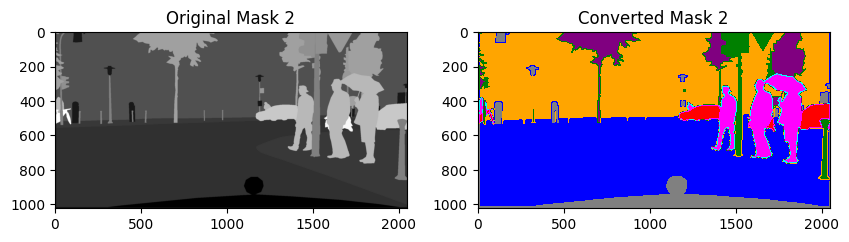

Original Mask 3 Unique Labels: [ 1  2  3  4  5  7  8  9 11 15 17 20 21 22 23 24 26 33]
Converted Mask 3 Unique Labels: [0 1 2 3 4 5 6 7]


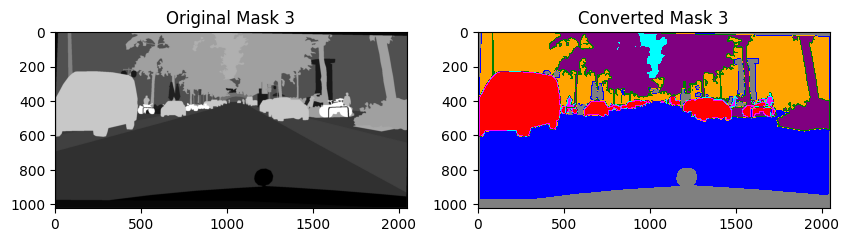

Original Mask 4 Unique Labels: [ 1  3  4  6  7  8  9 11 12 17 19 20 21 23 24 26 32]
Converted Mask 4 Unique Labels: [0 1 2 3 4 5 6 7]


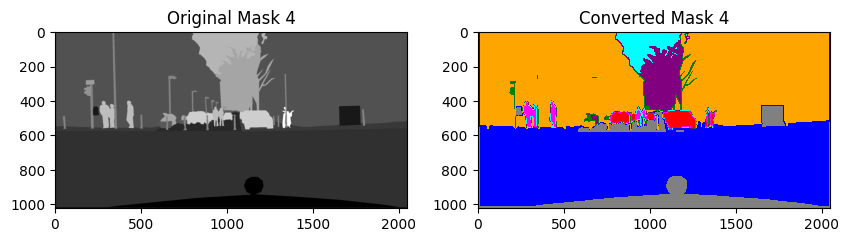

Original Mask 5 Unique Labels: [ 1  3  4  7  8  9 11 15 17 19 20 21 22 23 24 26]
Converted Mask 5 Unique Labels: [0 1 2 3 4 5 6 7]


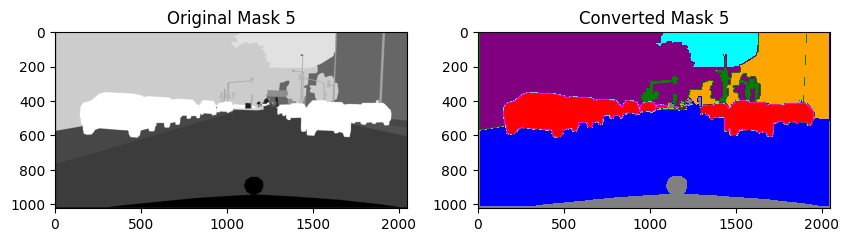

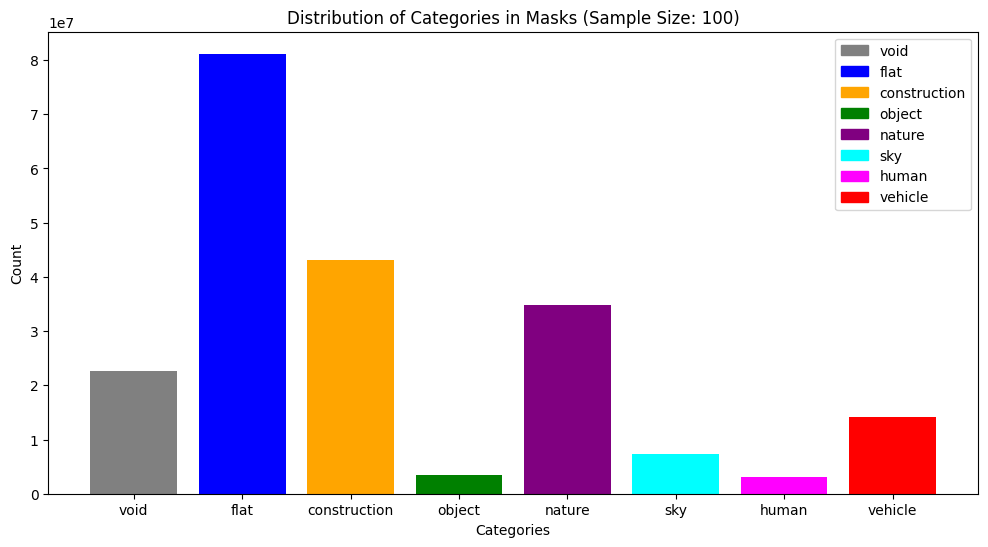

In [ ]:
# Définir les catégories et les couleurs
CATS = {
    'void': [0, 1, 2, 3, 4, 5, 6],
    'flat': [7, 8, 9, 10],
    'construction': [11, 12, 13, 14, 15, 16],
    'object': [17, 18, 19, 20],
    'nature': [21, 22],
    'sky': [23],
    'human': [24, 25],
    'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]
}

category_colors = {
    'void': 'gray',
    'flat': 'blue',
    'construction': 'orange',
    'object': 'green',
    'nature': 'purple',
    'sky': 'cyan',
    'human': 'magenta',
    'vehicle': 'red'
}

# Fonction pour convertir les masques
def _convert_mask(img):
    mask = np.zeros((img.shape[0], img.shape[1], 8), dtype=np.uint8)
    for i in range(-1, 34):
        if i in CATS['void']:
            mask[:, :, 0] = np.logical_or(mask[:, :, 0], (img == i))
        elif i in CATS['flat']:
            mask[:, :, 1] = np.logical_or(mask[:, :, 1], (img == i))
        elif i in CATS['construction']:
            mask[:, :, 2] = np.logical_or(mask[:, :, 2], (img == i))
        elif i in CATS['object']:
            mask[:, :, 3] = np.logical_or(mask[:, :, 3], (img == i))
        elif i in CATS['nature']:
            mask[:, :, 4] = np.logical_or(mask[:, :, 4], (img == i))
        elif i in CATS['sky']:
            mask[:, :, 5] = np.logical_or(mask[:, :, 5], (img == i))
        elif i in CATS['human']:
            mask[:, :, 6] = np.logical_or(mask[:, :, 6], (img == i))
        elif i in CATS['vehicle']:
            mask[:, :, 7] = np.logical_or(mask[:, :, 7], (img == i))
    return np.argmax(mask, axis=2).astype('uint8')

# Fonction pour charger les masques et extraire les labels par catégorie
def get_category_distribution(mask_paths):
    category_counts = {cat: 0 for cat in CATS.keys()}
    for mask_path in mask_paths:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        converted_mask = _convert_mask(mask)
        unique, counts = np.unique(converted_mask, return_counts=True)
        for label, count in zip(unique, counts):
            category = list(CATS.keys())[label]
            category_counts[category] += count
    return category_counts

# Fonction pour obtenir les chemins des masques
def get_mask_paths(mask_base_dir, sample_size=None):
    mask_paths = []
    for root, dirs, files in os.walk(mask_base_dir):
        for file in files:
            if file.endswith('_gtFine_labelIds.png'):
                mask_paths.append(os.path.join(root, file))
    if sample_size:
        mask_paths = random.sample(mask_paths, sample_size)
    return mask_paths

# Fonction pour visualiser quelques masques
def visualize_masks(mask_paths, num_samples=5):
    # Définir la palette de couleurs
    colors = [category_colors[cat] for cat in CATS.keys()]
    cmap = mcolors.ListedColormap(colors)
    norm = mcolors.BoundaryNorm(range(len(CATS) + 1), cmap.N)

    for i, mask_path in enumerate(random.sample(mask_paths, num_samples)):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        converted_mask = _convert_mask(mask)

        # Étape de débogage : Afficher les valeurs uniques dans les masques
        print(f"Original Mask {i+1} Unique Labels: {np.unique(mask)}")
        print(f"Converted Mask {i+1} Unique Labels: {np.unique(converted_mask)}")

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title(f'Original Mask {i+1}')
        plt.imshow(mask, cmap='gray')

        plt.subplot(1, 2, 2)
        plt.title(f'Converted Mask {i+1}')
        plt.imshow(converted_mask, cmap=cmap, norm=norm)

        plt.show()

# Chemin vers le répertoire des masques
mask_base_dir = '/content/drive/My Drive//data/gtFine/train'

# Définir la taille de l'échantillon
sample_size = 100  # Vous pouvez ajuster cette valeur selon vos besoins

# Obtenir les chemins des masques avec un échantillon
mask_paths = get_mask_paths(mask_base_dir, sample_size)

# Visualiser quelques masques pour vérifier
visualize_masks(mask_paths)

# Obtenir la distribution des catégories
category_distribution = get_category_distribution(mask_paths)

# Convertir la distribution en DataFrame pour une meilleure visualisation
df = pd.DataFrame(list(category_distribution.items()), columns=['Category', 'Count'])

# Mapper les couleurs pour chaque catégorie
df['Color'] = df['Category'].map(category_colors)

# Afficher la distribution sous forme de bar plot avec des couleurs
plt.figure(figsize=(12, 6))
plt.bar(df['Category'], df['Count'], color=df['Color'])
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title(f'Distribution of Categories in Masks (Sample Size: {sample_size})')

# Ajouter une légende
handles = [plt.Rectangle((0,0),1,1, color=category_colors[cat]) for cat in category_colors]
labels = [cat for cat in category_colors]
plt.legend(handles, labels)

plt.show()

### Exploration de la distribution des labels

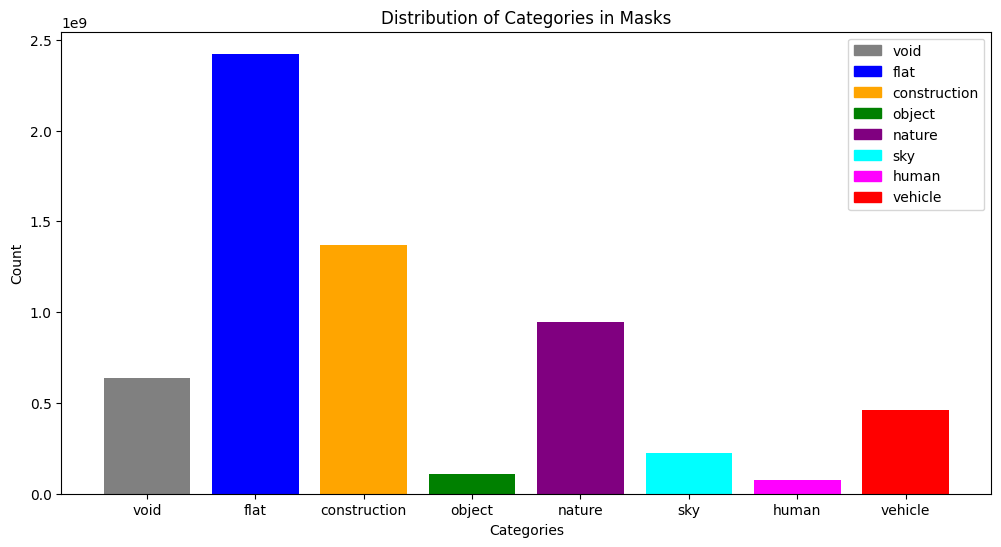

In [ ]:
# Définir les catégories et les couleurs
CATS = {
    'void': [0, 1, 2, 3, 4, 5, 6],
    'flat': [7, 8, 9, 10],
    'construction': [11, 12, 13, 14, 15, 16],
    'object': [17, 18, 19, 20],
    'nature': [21, 22],
    'sky': [23],
    'human': [24, 25],
    'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]
}

category_colors = {
    'void': 'gray',
    'flat': 'blue',
    'construction': 'orange',
    'object': 'green',
    'nature': 'purple',
    'sky': 'cyan',
    'human': 'magenta',
    'vehicle': 'red'
}

# Fonction pour convertir les masques
def _convert_mask(img):
    mask = np.zeros((img.shape[0], img.shape[1], 8), dtype=np.uint8)
    for i in range(-1, 34):
        if i in CATS['void']:
            mask[:, :, 0] = np.logical_or(mask[:, :, 0], (img == i))
        elif i in CATS['flat']:
            mask[:, :, 1] = np.logical_or(mask[:, :, 1], (img == i))
        elif i in CATS['construction']:
            mask[:, :, 2] = np.logical_or(mask[:, :, 2], (img == i))
        elif i in CATS['object']:
            mask[:, :, 3] = np.logical_or(mask[:, :, 3], (img == i))
        elif i in CATS['nature']:
            mask[:, :, 4] = np.logical_or(mask[:, :, 4], (img == i))
        elif i in CATS['sky']:
            mask[:, :, 5] = np.logical_or(mask[:, :, 5], (img == i))
        elif i in CATS['human']:
            mask[:, :, 6] = np.logical_or(mask[:, :, 6], (img == i))
        elif i in CATS['vehicle']:
            mask[:, :, 7] = np.logical_or(mask[:, :, 7], (img == i))
    return np.argmax(mask, axis=2).astype('uint8')

# Fonction pour charger les masques et extraire les labels par catégorie
def get_category_distribution(mask_paths):
    category_counts = {cat: 0 for cat in CATS.keys()}
    for mask_path in mask_paths:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        converted_mask = _convert_mask(mask)
        unique, counts = np.unique(converted_mask, return_counts=True)
        for label, count in zip(unique, counts):
            category = list(CATS.keys())[label]
            category_counts[category] += count
    return category_counts

# Fonction pour obtenir les chemins des masques
def get_mask_paths(mask_base_dir):
    mask_paths = []
    for root, dirs, files in os.walk(mask_base_dir):
        for file in files:
            if file.endswith('_gtFine_labelIds.png'):
                mask_paths.append(os.path.join(root, file))
    return mask_paths

# Chemin vers le répertoire des masques
mask_base_dir = '/content/drive/My Drive//data/gtFine/train'

# Obtenir les chemins des masques
mask_paths = get_mask_paths(mask_base_dir)

# Obtenir la distribution des catégories
category_distribution = get_category_distribution(mask_paths)

# Convertir la distribution en DataFrame pour une meilleure visualisation
df = pd.DataFrame(list(category_distribution.items()), columns=['Category', 'Count'])

# Mapper les couleurs pour chaque catégorie
df['Color'] = df['Category'].map(category_colors)

# Afficher la distribution sous forme de bar plot avec des couleurs
plt.figure(figsize=(12, 6))
plt.bar(df['Category'], df['Count'], color=df['Color'])
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Distribution of Categories in Masks')

# Ajouter une légende
handles = [plt.Rectangle((0,0),1,1, color=category_colors[cat]) for cat in category_colors]
labels = [cat for cat in category_colors]
plt.legend(handles, labels)

plt.show()

### Définition de la métrique personnalisée

In [4]:
class CustomMeanIoU(tf.keras.metrics.Metric):
    def __init__(self, name='mean_iou', num_classes=8, **kwargs):
        super(CustomMeanIoU, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.count_classes = self.add_weight(name='count_classes', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        if len(y_true.shape) == 4:
            y_true = tf.argmax(y_true, axis=-1)
            y_pred = tf.argmax(y_pred, axis=-1)

        mean_iou = 0.0
        class_count = 0.0

        for i in range(self.num_classes):
            true_class = K.cast(K.equal(y_true, i), dtype=tf.float32)
            pred_class = K.cast(K.equal(y_pred, i), dtype=tf.float32)

            intersection = K.sum(true_class * pred_class)
            union = K.sum(true_class) + K.sum(pred_class) - intersection

            iou = intersection / (union + K.epsilon())
            condition = K.equal(union, 0)
            mean_iou = K.switch(condition, mean_iou, mean_iou + iou)
            class_count = K.switch(condition, class_count, class_count + 1)

        self.total_iou.assign_add(mean_iou)
        self.count_classes.assign_add(class_count)

    def result(self):
        return self.total_iou / (self.count_classes + K.epsilon())

    def reset_state(self):
        self.total_iou.assign(0.0)
        self.count_classes.assign(0.0)

#### Générateur de données

#### Générateur avec augmentation

In [6]:
class DataLoadGenerator(Sequence):
    CATS = {
        'void': [0, 1, 2, 3, 4, 5, 6],
        'flat': [7, 8, 9, 10],
        'construction': [11, 12, 13, 14, 15, 16],
        'object': [17, 18, 19, 20],
        'nature': [21, 22],
        'sky': [23],
        'human': [24, 25],
        'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]
    }

    def __init__(self, image_paths, mask_paths, crop_x, crop_y, batch_size, augment=False, shuffle=True):
        """
        Générateur de données avec ou sans augmentation des images
        """
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.crop_x = crop_x
        self.crop_y = crop_y
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        batch_x = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.mask_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        x,y= self._prepare_data(batch_x,batch_y)
        return x,y

    def _prepare_data(self, image_paths, mask_paths):
        x = []
        y = []
        for idx, (img_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
            img, mask = self._get_image_and_mask(img_path, mask_path)
            if self.augment:
                img, mask = self._augment_image(img, mask)
            x.append(img)
            y.append(mask)
        x = np.array(x, dtype=np.float32) / 255.0
        y = np.array(y, dtype=np.uint8)
        y = np.expand_dims(y, axis=-1)
        y = to_categorical(y, num_classes=8)
        return x, y

    def _get_image_and_mask(self, img_path, mask_path):
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (self.crop_x, self.crop_y))
        mask = cv2.resize(mask, (self.crop_x, self.crop_y), interpolation=cv2.INTER_NEAREST)
        mask = self._convert_mask(mask)
        return img, mask

    def _convert_mask(self, img):
        mask = np.zeros((img.shape[0], img.shape[1], 8), dtype=np.uint8)
        for i in range(-1, 34):
            if i in self.CATS['void']:
                mask[:, :, 0] = np.logical_or(mask[:, :, 0], (img == i))
            elif i in self.CATS['flat']:
                mask[:, :, 1] = np.logical_or(mask[:, :, 1], (img == i))
            elif i in self.CATS['construction']:
                mask[:, :, 2] = np.logical_or(mask[:, :, 2], (img == i))
            elif i in self.CATS['object']:
                mask[:, :, 3] = np.logical_or(mask[:, :, 3], (img == i))
            elif i in self.CATS['nature']:
                mask[:, :, 4] = np.logical_or(mask[:, :, 4], (img == i))
            elif i in self.CATS['sky']:
                mask[:, :, 5] = np.logical_or(mask[:, :, 5], (img == i))
            elif i in self.CATS['human']:
                mask[:, :, 6] = np.logical_or(mask[:, :, 6], (img == i))
            elif i in self.CATS['vehicle']:
                mask[:, :, 7] = np.logical_or(mask[:, :, 7], (img == i))
        return np.argmax(mask, axis=2).astype('uint8')

    def _augment_image(self, img, mask):
        segmap = SegmentationMapsOnImage(mask, shape=img.shape)

        seq = iaa.Sequential([
            iaa.Affine(rotate=(-10, 10)),
            iaa.GammaContrast((0.5, 2.0)),
            iaa.Fliplr(0.5),
            iaa.CropAndPad(px=(-10, 10)),
            iaa.AdditiveGaussianNoise(scale=(0, 0.05*255))
        ])

        ia.seed(2)
        img_aug, segmap_aug = seq(image=img, segmentation_maps=segmap)
        final_img = img_aug
        final_mask = segmap_aug.get_arr()

        return final_img, final_mask

# Fonction pour obtenir les chemins des images et des masques
def get_image_and_mask_paths(image_base_dir, mask_base_dir):
    cities = os.listdir(image_base_dir)
    image_paths = []
    mask_paths = []
    for city in cities:
        city_image_dir = os.path.join(image_base_dir, city)
        city_mask_dir = os.path.join(mask_base_dir, city)
        images = os.listdir(city_image_dir)
        for img in images:
            mask = img.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
            mask_path = os.path.join(city_mask_dir, mask)
            if os.path.exists(mask_path):
                image_paths.append(os.path.join(city_image_dir, img))
                mask_paths.append(mask_path)
            else:
                print(f"Mask not found for image: {img}")
    print(f"Total images loaded from {image_base_dir}: {len(image_paths)}")
    print(f"Total masks loaded from {mask_base_dir}: {len(mask_paths)}")
    return image_paths, mask_paths

# Obtenir les chemins pour l'entraînement
train_image_base_dir = '/content/drive/My Drive//data/leftImg8bit/train'
train_mask_base_dir = '/content/drive/My Drive//data/gtFine/train'
train_image_paths, train_mask_paths = get_image_and_mask_paths(train_image_base_dir, train_mask_base_dir)

# Obtenir les chemins pour la validation
val_image_base_dir = '/content/drive/My Drive//data/leftImg8bit/val'
val_mask_base_dir = '/content/drive/My Drive//data/gtFine/val'
val_image_paths, val_mask_paths = get_image_and_mask_paths(val_image_base_dir, val_mask_base_dir)

# Obtenir les chemins pour le test
test_image_base_dir = '/content/drive/My Drive/data/leftImg8bit/test'
test_mask_base_dir = '/content/drive/My Drive//data/gtFine/test'
test_image_paths, test_mask_paths = get_image_and_mask_paths(test_image_base_dir, test_mask_base_dir)

# Création des DataLoaders
train_loader = DataLoadGenerator(train_image_paths, train_mask_paths, crop_x=512, crop_y=512, batch_size=8, augment=True)
val_loader = DataLoadGenerator(val_image_paths, val_mask_paths, crop_x=512, crop_y=512, batch_size=8, augment=False, shuffle=False)
test_loader = DataLoadGenerator(test_image_paths, test_mask_paths, crop_x=512, crop_y=512, batch_size=8, augment=False, shuffle=False)

print(f"Total batches in train_loader: {len(train_loader)}")
print(f"Total batches in val_loader: {len(val_loader)}")
print(f"Total batches in test_loader: {len(test_loader)}")

# Pour tester un lot de données d'entraînement et afficher la forme du masque d'origine :
x_train, y_train = train_loader[0]
print(x_train.shape, y_train.shape)  # Affiche la forme des lots de données générés

# Pour tester un lot de données de validation :
x_val, y_val = val_loader[0]
print(x_val.shape, y_val.shape)  # Affiche la forme des lots de données générés

# Pour tester un lot de données de test :
x_test, y_test = test_loader[0]
print(x_test.shape, y_test.shape)  # Affiche la forme des lots de données générés

Total images loaded from /content/drive/My Drive//data/leftImg8bit/train: 2975
Total masks loaded from /content/drive/My Drive//data/gtFine/train: 2975
Total images loaded from /content/drive/My Drive//data/leftImg8bit/val: 500
Total masks loaded from /content/drive/My Drive//data/gtFine/val: 500
Total images loaded from /content/drive/My Drive/data/leftImg8bit/test: 1525
Total masks loaded from /content/drive/My Drive//data/gtFine/test: 1525
Total batches in train_loader: 372
Total batches in val_loader: 63
Total batches in test_loader: 191
(8, 512, 512, 3) (8, 512, 512, 8)
(8, 512, 512, 3) (8, 512, 512, 8)
(8, 512, 512, 3) (8, 512, 512, 8)


#### Générateur sans augmentation

In [5]:
class DataLoadGeneratorSA(Sequence):
    CATS = {
        'void': [0, 1, 2, 3, 4, 5, 6],
        'flat': [7, 8, 9, 10],
        'construction': [11, 12, 13, 14, 15, 16],
        'object': [17, 18, 19, 20],
        'nature': [21, 22],
        'sky': [23],
        'human': [24, 25],
        'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]
    }

    def __init__(self, image_paths, mask_paths, crop_x, crop_y, batch_size, shuffle=True):
        """
        Générateur de données sans augmentation des images
        """
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.crop_x = crop_x
        self.crop_y = crop_y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        batch_x = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.mask_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        x, y = self._prepare_data(batch_x, batch_y)
        return x, y

    def _prepare_data(self, image_paths, mask_paths):
        x = []
        y = []
        for img_path, mask_path in zip(image_paths, mask_paths):
            img, mask = self._get_image_and_mask(img_path, mask_path)
            x.append(img)
            y.append(mask)
        x = np.array(x, dtype=np.float32) / 255.0
        y = np.array(y, dtype=np.uint8)
        y = np.expand_dims(y, axis=-1)
        y = to_categorical(y, num_classes=8)
        return x, y

    def _get_image_and_mask(self, img_path, mask_path):
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (self.crop_x, self.crop_y))
        mask = cv2.resize(mask, (self.crop_x, self.crop_y), interpolation=cv2.INTER_NEAREST)
        mask = self._convert_mask(mask)
        return img, mask

    def _convert_mask(self, img):
        mask = np.zeros((img.shape[0], img.shape[1], 8), dtype=np.uint8)
        for i in range(-1, 34):
            if i in self.CATS['void']:
                mask[:, :, 0] = np.logical_or(mask[:, :, 0], (img == i))
            elif i in self.CATS['flat']:
                mask[:, :, 1] = np.logical_or(mask[:, :, 1], (img == i))
            elif i in self.CATS['construction']:
                mask[:, :, 2] = np.logical_or(mask[:, :, 2], (img == i))
            elif i in self.CATS['object']:
                mask[:, :, 3] = np.logical_or(mask[:, :, 3], (img == i))
            elif i in self.CATS['nature']:
                mask[:, :, 4] = np.logical_or(mask[:, :, 4], (img == i))
            elif i in self.CATS['sky']:
                mask[:, :, 5] = np.logical_or(mask[:, :, 5], (img == i))
            elif i in self.CATS['human']:
                mask[:, :, 6] = np.logical_or(mask[:, :, 6], (img == i))
            elif i in self.CATS['vehicle']:
                mask[:, :, 7] = np.logical_or(mask[:, :, 7], (img == i))
        return np.argmax(mask, axis=2).astype('uint8')

# Fonction pour obtenir les chemins des images et des masques
def get_image_and_mask_paths(image_base_dir, mask_base_dir):
    cities = os.listdir(image_base_dir)
    image_paths = []
    mask_paths = []
    for city in cities:
        city_image_dir = os.path.join(image_base_dir, city)
        city_mask_dir = os.path.join(mask_base_dir, city)
        images = os.listdir(city_image_dir)
        for img in images:
            mask = img.replace('_leftImg8bit.png', '_gtFine_labelIds.png')
            mask_path = os.path.join(city_mask_dir, mask)
            if os.path.exists(mask_path):
                image_paths.append(os.path.join(city_image_dir, img))
                mask_paths.append(mask_path)
            else:
                print(f"Mask not found for image: {img}")
    print(f"Total images loaded from {image_base_dir}: {len(image_paths)}")
    print(f"Total masks loaded from {mask_base_dir}: {len(mask_paths)}")
    return image_paths, mask_paths

# Obtenir les chemins pour l'entraînement
train_image_base_dir = '/content/drive/My Drive//data/leftImg8bit/train'
train_mask_base_dir = '/content/drive/My Drive//data/gtFine/train'
train_image_paths, train_mask_paths = get_image_and_mask_paths(train_image_base_dir, train_mask_base_dir)

# Obtenir les chemins pour la validation
val_image_base_dir = '/content/drive/My Drive//data/leftImg8bit/val'
val_mask_base_dir = '/content/drive/My Drive//data/gtFine/val'
val_image_paths, val_mask_paths = get_image_and_mask_paths(val_image_base_dir, val_mask_base_dir)

# Obtenir les chemins pour le test
test_image_base_dir = '/content/drive/My Drive/data/leftImg8bit/test'
test_mask_base_dir = '/content/drive/My Drive//data/gtFine/test'
test_image_paths, test_mask_paths = get_image_and_mask_paths(test_image_base_dir, test_mask_base_dir)

# Création des DataLoaders sans augmentation
train_loaderSA = DataLoadGeneratorSA(train_image_paths, train_mask_paths, crop_x=512, crop_y=512, batch_size=8, shuffle=True)
val_loaderSA = DataLoadGeneratorSA(val_image_paths, val_mask_paths, crop_x=512, crop_y=512, batch_size=8, shuffle=False)
test_loaderSA = DataLoadGeneratorSA(test_image_paths, test_mask_paths, crop_x=512, crop_y=512, batch_size=8, shuffle=False)

print(f"Total batches in train_loader: {len(train_loaderSA)}")
print(f"Total batches in val_loader: {len(val_loaderSA)}")
print(f"Total batches in test_loader: {len(test_loaderSA)}")

# Pour tester un lot de données d'entraînement et afficher la forme du masque d'origine :
x_train_SA, y_train_SA = train_loaderSA[0]
print(x_train_SA.shape, y_train_SA.shape)  # Affiche la forme des lots de données générés

# Pour tester un lot de données de validation :
x_val_SA, y_val_SA = val_loaderSA[0]
print(x_val_SA.shape, y_val_SA.shape)  # Affiche la forme des lots de données générés

# Pour tester un lot de données de test :
x_test_SA, y_test_SA = test_loaderSA[0]
print(x_test_SA.shape, y_test_SA.shape)  # Affiche la forme des lots de données générés


Total images loaded from /content/drive/My Drive//data/leftImg8bit/train: 2975
Total masks loaded from /content/drive/My Drive//data/gtFine/train: 2975
Total images loaded from /content/drive/My Drive//data/leftImg8bit/val: 500
Total masks loaded from /content/drive/My Drive//data/gtFine/val: 500
Total images loaded from /content/drive/My Drive/data/leftImg8bit/test: 1525
Total masks loaded from /content/drive/My Drive//data/gtFine/test: 1525
Total batches in train_loader: 372
Total batches in val_loader: 63
Total batches in test_loader: 191
(8, 512, 512, 3) (8, 512, 512, 8)
(8, 512, 512, 3) (8, 512, 512, 8)
(8, 512, 512, 3) (8, 512, 512, 8)


### Création du répertoire de sauvegarde

In [6]:
# Définir le répertoire de sauvegarde sur Google Drive
save_dir = '/content/drive/My Drive/models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

### Modèle Mini_Unet

#### Modèle Mini_Unet avec augmentation

In [ ]:
def mini_unet(input_size=(512, 512, 3), n_classes=8):
    inputs = Input(input_size)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    up1 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(up1)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up2 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up2)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up3 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    output = Conv2D(n_classes, (1, 1), activation='softmax')(conv7)

    model = Model(inputs=inputs, outputs=output)
    return model

# Créer le modèle avec input_size = (512, 512, 3)
model = mini_unet(input_size=(512, 512, 3), n_classes=8)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[CustomMeanIoU(num_classes=8)])

# Chemin complet pour enregistrer le modèle complet
model_filepath_unet = os.path.join(save_dir, 'mini_unet.weights.h5')

# Définir les callbacks
model_checkpoint = ModelCheckpoint(model_filepath_unet, monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Définir steps_per_epoch et validation_steps
# Remplacer train_loader et val_loader par vos générateurs de données ou DataLoader
steps_per_epoch = len(train_loader)
validation_steps = len(val_loader)

# Assurez-vous que steps_per_epoch et validation_steps sont des entiers positifs
if steps_per_epoch <= 0 or validation_steps <= 0:
    raise ValueError("steps_per_epoch et validation_steps doivent être des entiers positifs")

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 256, 256, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
import gc
gc.collect()

371

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Vérifier que les formes des données correspondent à celles attendues par le modèle
print("Forme des données d'entraînement :", x_train.shape, y_train.shape)
print("Forme des données de validation :", x_val.shape, y_val.shape)


# Calculer le nombre de lots de données pour l'entraînement et la validation
steps_per_epoch = len(train_loader)
validation_steps = len(val_loader)

# Démarrer l'entraînement du modèle
history = model.fit(
    train_loader,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_loader,
    validation_steps=validation_steps,
    epochs=50,
    callbacks=[model_checkpoint, early_stopping]
)

# Enregistrer le modèle complet après l'entraînement
model.save(model_filepath_unet)

Forme des données d'entraînement : (8, 512, 512, 3) (8, 512, 512, 8)
Forme des données de validation : (8, 512, 512, 3) (8, 512, 512, 8)
Epoch 1/50
372/372 [==============================] - 2620s 7s/step - loss: 1.3502 - mean_iou: 0.2426 - val_loss: 1.6420 - val_mean_iou: 0.1275
Epoch 2/50
372/372 [==============================] - 494s 1s/step - loss: 0.8400 - mean_iou: 0.3830 - val_loss: 1.7752 - val_mean_iou: 0.1847
Epoch 3/50
372/372 [==============================] - 491s 1s/step - loss: 0.7254 - mean_iou: 0.4419 - val_loss: 1.8097 - val_mean_iou: 0.1911
Epoch 4/50
372/372 [==============================] - 493s 1s/step - loss: 0.6218 - mean_iou: 0.4875 - val_loss: 1.4776 - val_mean_iou: 0.2306
Epoch 5/50
372/372 [==============================] - 492s 1s/step - loss: 0.5567 - mean_iou: 0.5206 - val_loss: 1.2843 - val_mean_iou: 0.2642
Epoch 6/50
372/372 [==============================] - 493s 1s/step - loss: 0.5212 - mean_iou: 0.5430 - val_loss: 1.3374 - val_mean_iou: 0.3009
Epoc

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Modèle Mini_Unet sans augmentation

In [20]:
def mini_unet_SA(input_size=(512, 512, 3), n_classes=8):
    inputs = Input(input_size)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    up1 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(up1)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up2 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up2)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up3 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    output = Conv2D(n_classes, (1, 1), activation='softmax')(conv7)

    model = Model(inputs=inputs, outputs=output)
    return model

# Créer le modèle avec input_size = (512, 512, 3)
model_SA = mini_unet_SA(input_size=(512, 512, 3), n_classes=8)
model_SA.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[CustomMeanIoU(num_classes=8)])

# Chemin complet pour enregistrer le modèle complet
model_filepath_unet_sa = os.path.join(save_dir, 'mini_unet_SA.weights.keras')
model_filepath_unet_sa_complete = os.path.join(save_dir, 'mini_unet_SA_complete.keras')

# Définir les callbacks
model_checkpoint_SA = ModelCheckpoint(model_filepath_unet_sa, monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping_SA = EarlyStopping(monitor='val_loss', patience=4)

# Définir steps_per_epoch et validation_steps
# Remplacer train_loader et val_loader par vos générateurs de données ou DataLoader
steps_per_epoch = len(train_loaderSA)
validation_steps = len(val_loaderSA)

# Définir une classe de callback pour sauvegarder le modèle complet
class ModelSaverunet(tf.keras.callbacks.Callback):
    def on_train_end(self, logs=None):
        model_vgg_sa.save(model_filepath_vgg_sa_complete)

model_saver_unet = ModelSaverunet()


In [21]:
model_SA.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d_21 (Conv2D)          (None, 512, 512, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 conv2d_22 (Conv2D)          (None, 512, 512, 64)         36928     ['conv2d_21[0][0]']           
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 256, 256, 64)         0         ['conv2d_22[0][0]']           
 g2D)                                                                                       

#### Entrainement du modèle

In [22]:
# Vérifier que les formes des données correspondent à celles attendues par le modèle
print("Forme des données d'entraînement :", x_train_SA.shape, y_train_SA.shape)
print("Forme des données de validation :", x_val_SA.shape, y_val_SA.shape)
print("Forme des données de test :", x_test_SA.shape, y_test_SA.shape)


# Calculer le nombre de lots de données pour l'entraînement et la validation
steps_per_epoch = len(train_loaderSA)
validation_steps = len(val_loaderSA)

# Démarrer l'entraînement du modèle
history = model_SA.fit(
    train_loaderSA,
    workers=30,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_loaderSA,
    validation_steps=validation_steps,
    epochs=20,
    callbacks=[model_checkpoint_SA, early_stopping_SA, model_saver_unet]
)

# Enregistrer le modèle complet après l'entraînement
model_SA.save(model_filepath_unet_sa_complete)

Forme des données d'entraînement : (8, 512, 512, 3) (8, 512, 512, 8)
Forme des données de validation : (8, 512, 512, 3) (8, 512, 512, 8)
Forme des données de test : (8, 512, 512, 3) (8, 512, 512, 8)
Epoch 1/20
372/372 [==============================] - 769s 2s/step - loss: 1.2731 - mean_iou: 0.2578 - val_loss: 0.8626 - val_mean_iou: 0.3741
Epoch 2/20
372/372 [==============================] - 135s 357ms/step - loss: 0.7491 - mean_iou: 0.4220 - val_loss: 0.7115 - val_mean_iou: 0.4404
Epoch 3/20
372/372 [==============================] - 134s 356ms/step - loss: 0.5971 - mean_iou: 0.4937 - val_loss: 0.5515 - val_mean_iou: 0.5183
Epoch 4/20
372/372 [==============================] - 134s 356ms/step - loss: 0.5087 - mean_iou: 0.5418 - val_loss: 0.5390 - val_mean_iou: 0.5329
Epoch 5/20
372/372 [==============================] - 133s 353ms/step - loss: 0.4493 - mean_iou: 0.5787 - val_loss: 0.5635 - val_mean_iou: 0.5446
Epoch 6/20
372/372 [==============================] - 134s 356ms/step - lo

### Modèle VGG16 sans augmentation


In [23]:
def vgg16_sa(input_size=(512, 512, 3), n_classes=8):
    inputs = Input(input_size)

    # Redimensionner les images d'entrée à (224, 224, 3) pour VGG16
    resized_inputs = Lambda(lambda x: tf.image.resize(x, (224, 224)))(inputs)
    preprocessed_inputs = Lambda(preprocess_input)(resized_inputs)

    # Encoder (VGG16)
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=preprocessed_inputs)
    for layer in vgg16.layers:
        layer.trainable = False

    block3_pool = vgg16.get_layer("block3_pool").output  # (None, 28, 28, 256)
    block4_pool = vgg16.get_layer("block4_pool").output  # (None, 14, 14, 512)
    block5_conv3 = vgg16.get_layer("block5_conv3").output  # (None, 7, 7, 512)

    # Decoder
    up1 = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(block5_conv3)  # (None, 14, 14, 512)
    up1 = Conv2D(512, (3, 3), activation='relu', padding='same')(up1)
    block4_pool_resized = UpSampling2D(size=(2, 2))(block4_pool)  # Redimensionner block4_pool pour correspondre à up1
    up1 = concatenate([up1, block4_pool_resized], axis=-1)  # (None, 14, 14, 1024)

    up2 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(up1)  # (None, 28, 28, 256)
    up2 = Conv2D(256, (3, 3), activation='relu', padding='same')(up2)
    block3_pool_resized = UpSampling2D(size=(2, 2))(block3_pool)  # Redimensionner block3_pool pour correspondre à up2
    up2 = concatenate([up2, block3_pool_resized], axis=-1)  # (None, 28, 28, 512)

    up3 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(up2)  # (None, 56, 56, 128)
    up3 = Conv2D(128, (3, 3), activation='relu', padding='same')(up3)

    up4 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(up3)  # (None, 112, 112, 64)
    up4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)

    up5 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(up4)  # (None, 224, 224, 32)
    up5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up5)

    # Redimensionner pour revenir à la taille d'origine (512, 512)
    final_upsampling = UpSampling2D(size=(2, 2))(up5)  # (None, 448, 448, 32)
    final_upsampling = Lambda(lambda x: tf.image.resize(x, (512, 512)))(final_upsampling)  # (None, 512, 512, 32)

    output = Conv2D(n_classes, (1, 1), activation='softmax')(final_upsampling)

    model = Model(inputs=inputs, outputs=output)
    return model

# Créer le modèle avec input_size = (512, 512, 3)
model_vgg_sa = vgg16_sa(input_size=(512, 512, 3), n_classes=8)
model_vgg_sa.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[CustomMeanIoU(num_classes=8)])

# Chemin complet pour enregistrer le modèle complet
model_filepath_vgg_sa = os.path.join(save_dir, 'vgg16_sa.weights.keras')
model_filepath_vgg_sa_complete = os.path.join(save_dir, 'vgg16_sa_complete.keras')

# Définir les callbacks pour surveiller dice_coefficient
model_checkpoint_vgg_sa = ModelCheckpoint(model_filepath_vgg_sa, monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping_vgg_sa = EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Définir une classe de callback pour sauvegarder le modèle complet
class ModelSaversa(tf.keras.callbacks.Callback):
    def on_train_end(self, logs=None):
        model_vgg_sa.save(model_filepath_vgg_sa_complete)

model_saver_sa = ModelSaversa()

In [24]:
model_vgg_sa.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 lambda_3 (Lambda)           (None, 224, 224, 3)          0         ['input_4[0][0]']             
                                                                                                  
 lambda_4 (Lambda)           (None, 224, 224, 3)          0         ['lambda_3[0][0]']            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['lambda_4[0][0]']            
                                                                                            

In [25]:
import gc
gc.collect()

4443

In [26]:
tf.keras.backend.clear_session()

In [27]:
!nvidia-smi

Fri May 24 18:12:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              50W / 400W |  35273MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [28]:
# Vérifier que les formes des données correspondent à celles attendues par le modèle
print("Forme des données d'entraînement :", x_train_SA.shape, y_train_SA.shape)
print("Forme des données de validation :", x_val_SA.shape, y_val_SA.shape)
print("Forme des données de test :", x_test_SA.shape, y_test_SA.shape)


# Calculer le nombre de lots de données pour l'entraînement et la validation
steps_per_epoch = len(train_loaderSA)
validation_steps = len(val_loaderSA)

# Démarrer l'entraînement du modèle
history = model_vgg_sa.fit(
    train_loaderSA,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_loaderSA,
    validation_steps=validation_steps,
    epochs=20,
    callbacks=[model_checkpoint_vgg_sa, early_stopping_vgg_sa, model_saver_sa]
)

# Enregistrer le modèle complet après l'entraînement
model_vgg_sa.save(model_filepath_vgg_sa_complete)

Forme des données d'entraînement : (8, 512, 512, 3) (8, 512, 512, 8)
Forme des données de validation : (8, 512, 512, 3) (8, 512, 512, 8)
Forme des données de test : (8, 512, 512, 3) (8, 512, 512, 8)
Epoch 1/20
372/372 [==============================] - 462s 1s/step - loss: 1.2592 - mean_iou: 0.1893 - val_loss: 0.9897 - val_mean_iou: 0.2125
Epoch 2/20
372/372 [==============================] - 445s 1s/step - loss: 0.9666 - mean_iou: 0.2373 - val_loss: 0.9330 - val_mean_iou: 0.2528
Epoch 3/20
372/372 [==============================] - 445s 1s/step - loss: 0.9140 - mean_iou: 0.2853 - val_loss: 0.9401 - val_mean_iou: 0.2997
Epoch 4/20
372/372 [==============================] - 447s 1s/step - loss: 0.8921 - mean_iou: 0.3033 - val_loss: 0.9126 - val_mean_iou: 0.3074
Epoch 5/20
372/372 [==============================] - 446s 1s/step - loss: 0.8691 - mean_iou: 0.3183 - val_loss: 0.9066 - val_mean_iou: 0.2989
Epoch 6/20
372/372 [==============================] - 446s 1s/step - loss: 0.8549 - me

### Modèle VGG16 avec augmentation

### Modèle VGG16 avec augmentation

In [ ]:
def vgg16(input_size=(512, 512, 3), n_classes=8):
    inputs = Input(input_size)

    # Redimensionner les images d'entrée à (224, 224, 3) pour VGG16
    resized_inputs = Lambda(lambda x: tf.image.resize(x, (224, 224)))(inputs)
    preprocessed_inputs = Lambda(preprocess_input)(resized_inputs)

    # Encoder (VGG16)
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=preprocessed_inputs)
    for layer in vgg16.layers:
        layer.trainable = False

    block3_pool = vgg16.get_layer("block3_pool").output  # (None, 28, 28, 256)
    block4_pool = vgg16.get_layer("block4_pool").output  # (None, 14, 14, 512)
    block5_conv3 = vgg16.get_layer("block5_conv3").output  # (None, 7, 7, 512)

    # Decoder
    up1 = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(block5_conv3)  # (None, 14, 14, 512)
    up1 = Conv2D(512, (3, 3), activation='relu', padding='same')(up1)
    block4_pool_resized = UpSampling2D(size=(2, 2))(block4_pool)  # Redimensionner block4_pool pour correspondre à up1
    up1 = concatenate([up1, block4_pool_resized], axis=-1)  # (None, 14, 14, 1024)

    up2 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(up1)  # (None, 28, 28, 256)
    up2 = Conv2D(256, (3, 3), activation='relu', padding='same')(up2)
    block3_pool_resized = UpSampling2D(size=(2, 2))(block3_pool)  # Redimensionner block3_pool pour correspondre à up2
    up2 = concatenate([up2, block3_pool_resized], axis=-1)  # (None, 28, 28, 512)

    up3 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(up2)  # (None, 56, 56, 128)
    up3 = Conv2D(128, (3, 3), activation='relu', padding='same')(up3)

    up4 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(up3)  # (None, 112, 112, 64)
    up4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up4)

    up5 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(up4)  # (None, 224, 224, 32)
    up5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up5)

    # Redimensionner pour revenir à la taille d'origine (512, 512)
    final_upsampling = UpSampling2D(size=(2, 2))(up5)  # (None, 448, 448, 32)
    final_upsampling = Lambda(lambda x: tf.image.resize(x, (512, 512)))(final_upsampling)  # (None, 512, 512, 32)

    output = Conv2D(n_classes, (1, 1), activation='softmax')(final_upsampling)

    model = Model(inputs=inputs, outputs=output)
    return model

# Créer le modèle avec input_size = (512, 512, 3)
model_vgg = vgg16(input_size=(512, 512, 3), n_classes=8)
model_vgg.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[CustomMeanIoU(num_classes=8)])

# Chemin complet pour enregistrer le modèle complet
model_filepath_vgg_weights = os.path.join(save_dir, 'vgg16.weights.keras')
model_filepath_vgg_complete = os.path.join(save_dir, 'vgg16_complete.keras')

# Définir les callbacks pour surveiller dice_coefficient
model_checkpoint_vgg = ModelCheckpoint(model_filepath_vgg_weights, monitor='val_loss', save_best_only=True, save_weights_only=True)
early_stopping_vgg = EarlyStopping(monitor='val_loss', patience=5, mode='min')

# Définir une classe de callback pour sauvegarder le modèle complet
class ModelSaver(tf.keras.callbacks.Callback):
    def on_train_end(self, logs=None):
        model_vgg.save(model_filepath_vgg_complete)

model_saver = ModelSaver()

In [ ]:
model_vgg.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 lambda_6 (Lambda)           (None, 224, 224, 3)          0         ['input_3[0][0]']             
                                                                                                  
 lambda_7 (Lambda)           (None, 224, 224, 3)          0         ['lambda_6[0][0]']            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['lambda_7[0][0]']            
                                                                                            

In [13]:
# Vérifier que les formes des données correspondent à celles attendues par le modèle
print("Forme des données d'entraînement :", x_train.shape, y_train.shape)
print("Forme des données de validation :", x_val.shape, y_val.shape)
print("Forme des données de test :", x_test.shape, y_test.shape)


# Calculer le nombre de lots de données pour l'entraînement et la validation
steps_per_epoch = len(train_loader)
validation_steps = len(val_loader)

# Démarrer l'entraînement du modèle
history = model_vgg.fit(
    train_loader,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_loader,
    validation_steps=validation_steps,
    epochs=20,
    callbacks=[model_checkpoint_vgg, early_stopping_vgg]
)

# Enregistrer le modèle complet après l'entraînement
model_vgg.save(model_filepath_vgg_complete)

Forme des données d'entraînement : (8, 512, 512, 3) (8, 512, 512, 8)
Forme des données de validation : (8, 512, 512, 3) (8, 512, 512, 8)
Forme des données de test : (8, 512, 512, 3) (8, 512, 512, 8)
Epoch 1/20
372/372 [==============================] - 718s 2s/step - loss: 0.8634 - mean_iou: 0.3203 - val_loss: 1.3518 - val_mean_iou: 0.2781
Epoch 2/20
372/372 [==============================] - 630s 2s/step - loss: 0.8542 - mean_iou: 0.3270 - val_loss: 1.4083 - val_mean_iou: 0.2867
Epoch 3/20
372/372 [==============================] - 626s 2s/step - loss: 0.8509 - mean_iou: 0.3296 - val_loss: 1.5794 - val_mean_iou: 0.2716
Epoch 4/20
372/372 [==============================] - 628s 2s/step - loss: 0.8439 - mean_iou: 0.3349 - val_loss: 1.4935 - val_mean_iou: 0.2533
Epoch 5/20
372/372 [==============================] - 622s 2s/step - loss: 0.8397 - mean_iou: 0.3366 - val_loss: 1.6113 - val_mean_iou: 0.2900
Epoch 6/20
372/372 [==============================] - 624s 2s/step - loss: 0.8380 - me

### Inferences

In [21]:
import gc
gc.collect()

Exception ignored in: <function _xla_gc_callback at 0x7a75a7890670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


1523

In [23]:
tf.keras.backend.clear_session()

In [17]:
# Effectuer des prédictions sur les données de test par lots
all_predictions = []
all_true_labels = []

# Itérer à travers les lots de données du DataLoader
for x_test, y_test in test_loaderSA:
    predictions = model_SA.predict(x_test)  # Désactiver les messages de progression
    all_predictions.append(predictions)
    all_true_labels.append(y_test)

# Convertir les prédictions en étiquettes de classes
all_predictions = np.concatenate(all_predictions, axis=0)
predicted_classes = np.argmax(all_predictions, axis=-1)

# Convertir les étiquettes vraies en classes
all_true_labels = np.concatenate(all_true_labels, axis=0)
true_classes = np.argmax(all_true_labels, axis=-1)

# Afficher les formes pour vérifier
print("Forme des prédictions :", all_predictions.shape)
print("Forme des classes prédites :", predicted_classes.shape)
print("Forme des classes vraies :", true_classes.shape)

1/1 [==============================] - 0s 27ms/step
Forme des prédictions : (1525, 512, 512, 8)
Forme des classes prédites : (1525, 512, 512)
Forme des classes vraies : (1525, 512, 512)


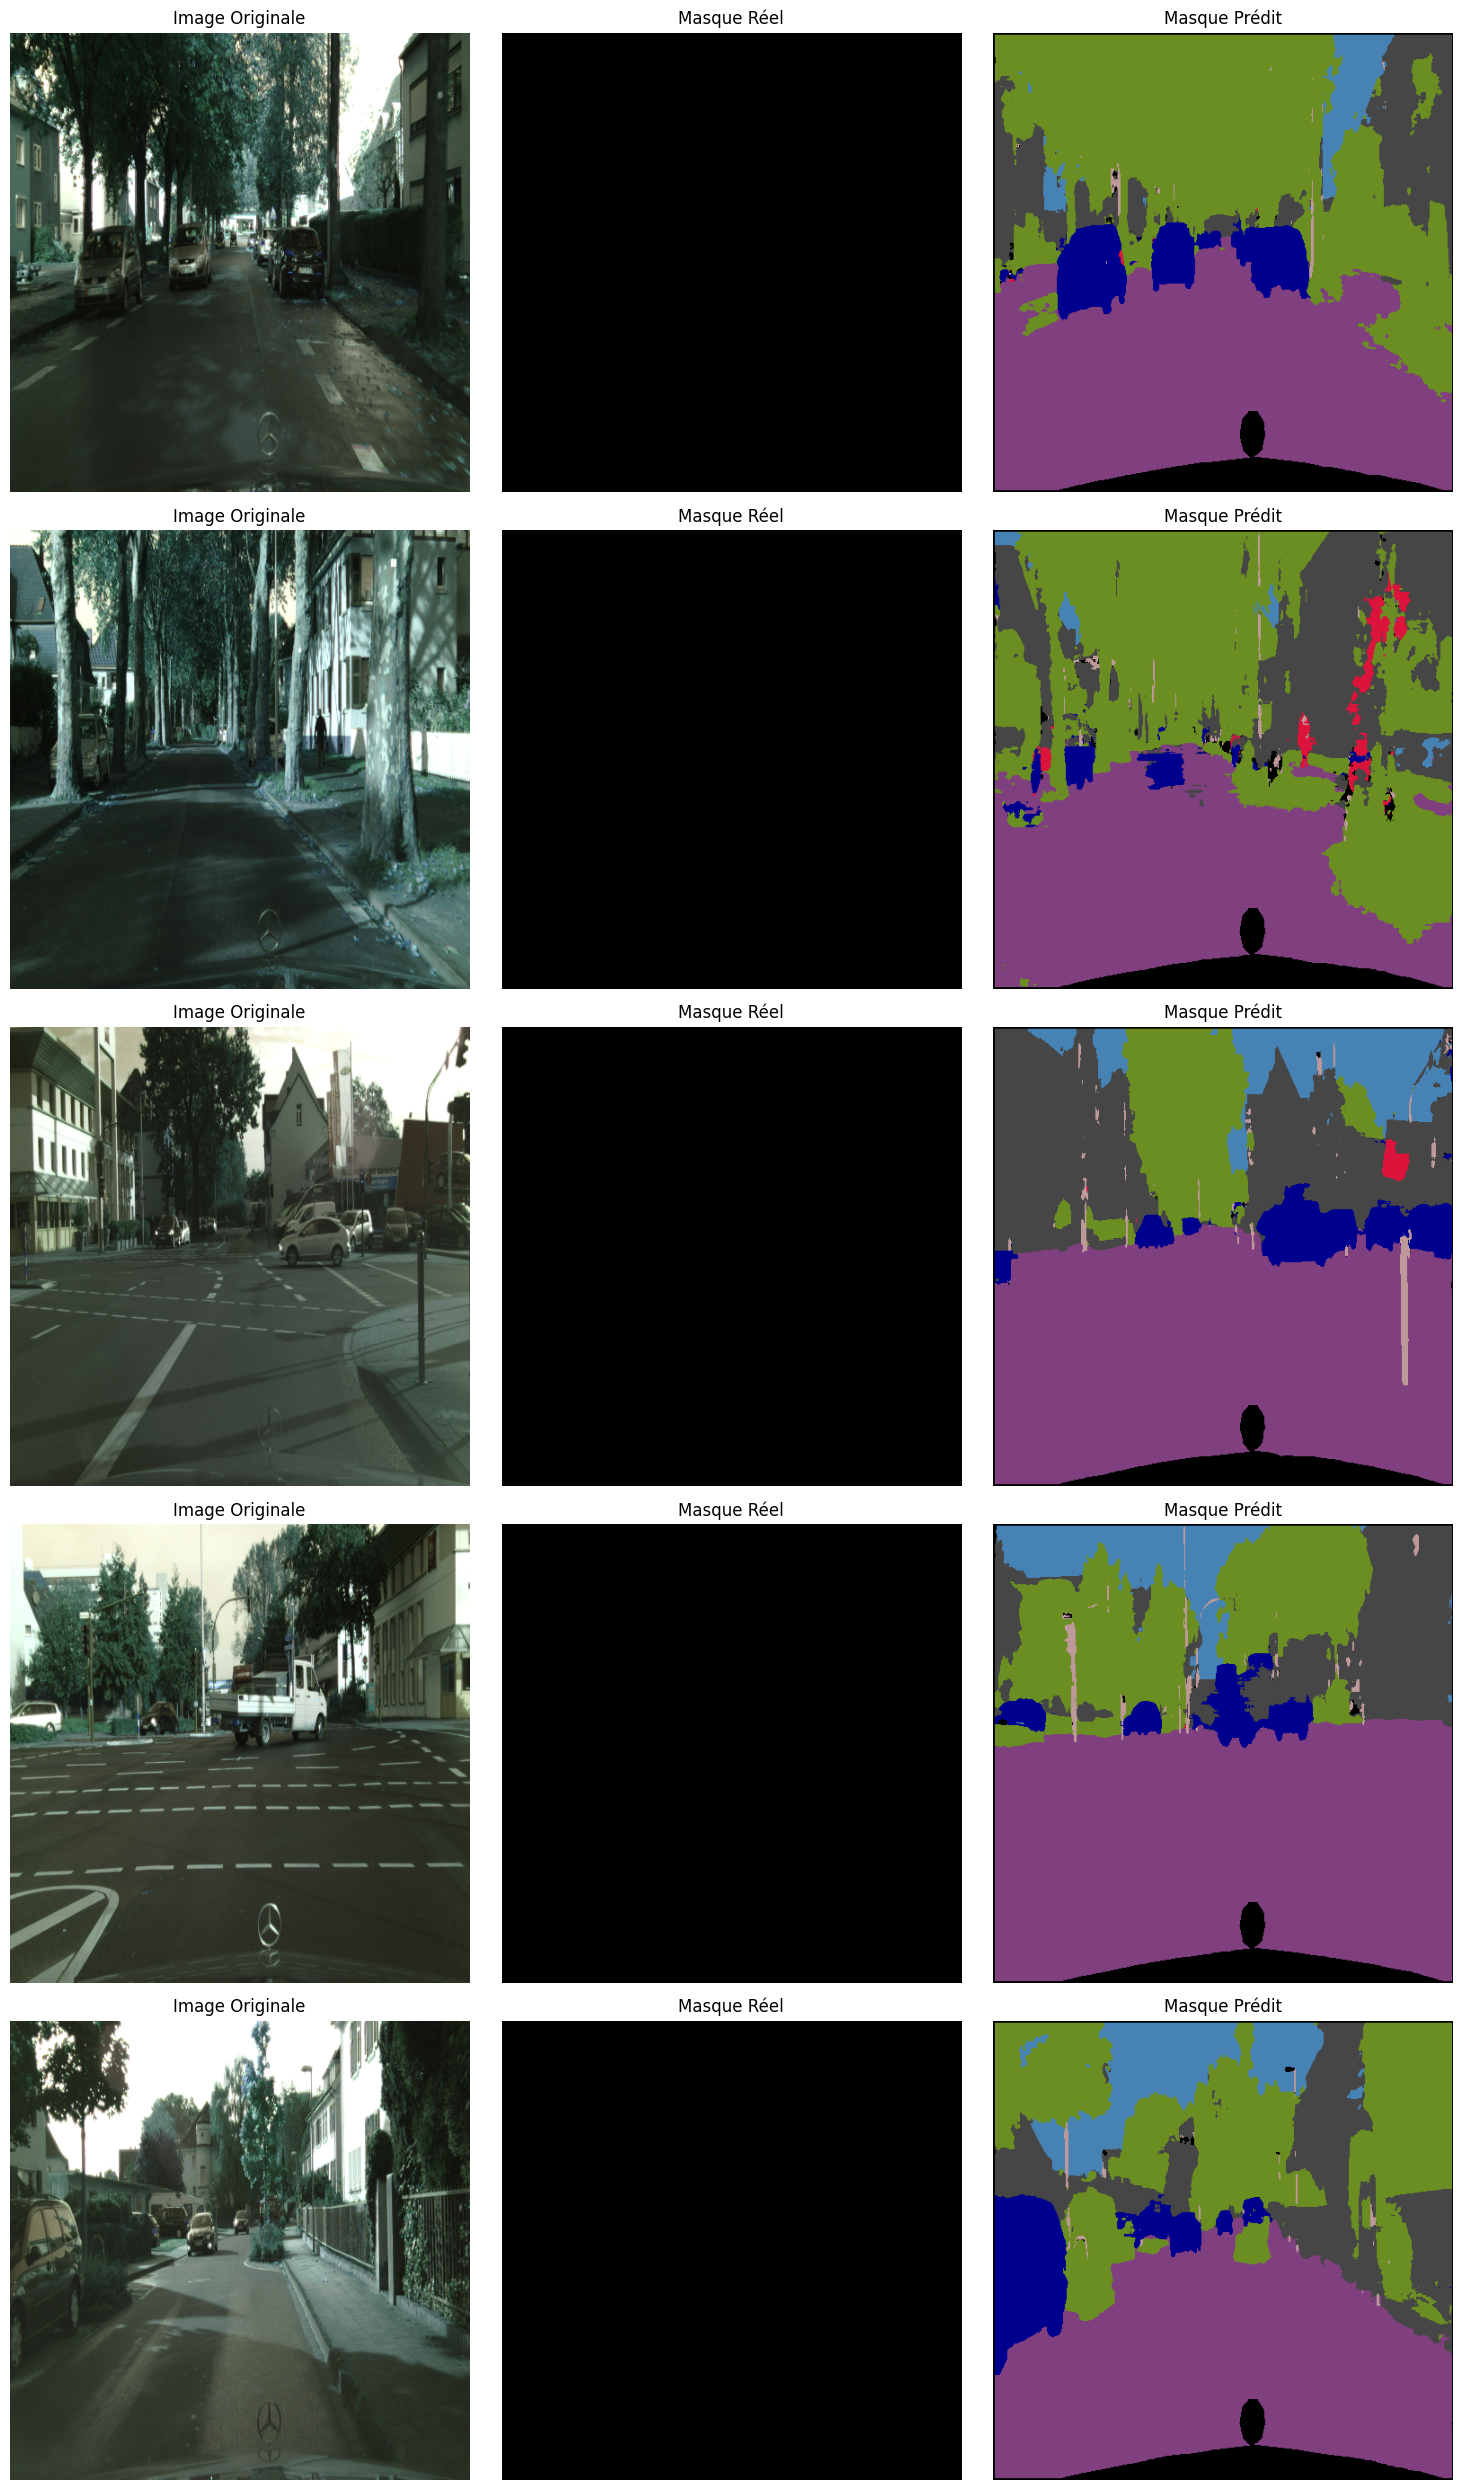

In [18]:
# Définir une palette de couleurs pour chaque classe
PALETTE = np.array([
    [0, 0, 0],        # void
    [128, 64, 128],   # flat
    [70, 70, 70],     # construction
    [190, 153, 153],  # object
    [107, 142, 35],   # nature
    [70, 130, 180],   # sky
    [220, 20, 60],    # human
    [0, 0, 142]       # vehicle
])

# Convertir les masques en couleur
def convert_mask_to_color(mask):
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for i in range(8):
        color_mask[mask == i] = PALETTE[i]
    return color_mask

# Visualiser des exemples d'images avec leurs masques correspondants
def visualize_predictions(images, true_labels, predictions, num_examples=5):
    fig, axes = plt.subplots(num_examples, 3, figsize=(15, num_examples * 5))
    axes = axes.ravel()

    for i in range(num_examples):
        # Charger l'image
        img = images[i]
        true_mask = convert_mask_to_color(true_labels[i])
        pred_mask = convert_mask_to_color(predictions[i])

        # Afficher l'image originale
        axes[3*i].imshow(img)
        axes[3*i].set_title("Image Originale")
        axes[3*i].axis('off')

        # Afficher le masque réel
        axes[3*i + 1].imshow(true_mask)
        axes[3*i + 1].set_title("Masque Réel")
        axes[3*i + 1].axis('off')

        # Afficher le masque prédit
        axes[3*i + 2].imshow(pred_mask)
        axes[3*i + 2].set_title("Masque Prédit")
        axes[3*i + 2].axis('off')

    plt.tight_layout()
    plt.show()

# Visualiser les prédictions
visualize_predictions(x_test_SA, true_classes, predicted_classes, num_examples=5)